In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d deadskull7/fer2013

Saving kaggle.json to kaggle.json
 92% 89.0M/96.6M [00:01<00:00, 46.5MB/s]
100% 96.6M/96.6M [00:01<00:00, 59.0MB/s]


In [2]:
!unzip fer2013.zip  && rm fer2013.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


In [12]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


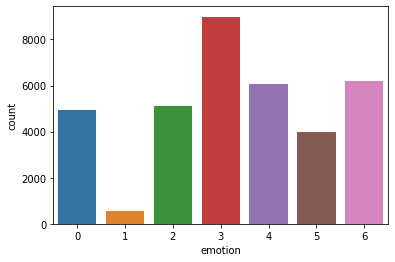

In [4]:
df = pd.read_csv('fer2013.csv')
#{0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
sns.countplot(df.emotion)
pyplot.show()

In [5]:
INTERESTED_LABELS = [3, 4, 6]
df = df[df.emotion.isin(INTERESTED_LABELS)]
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)

In [6]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [8]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]
X_train = X_train / 255.
X_valid = X_valid / 255.

In [9]:
def build_net(optim):
    model = Sequential(name='Emotion_CNN')

    model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(48, 48, 1),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_1'))
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Conv2D(filters=64,kernel_size=(5,5),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_2'))
    model.add(BatchNormalization(name='batchnorm_2'))
    
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    model.add(Dropout(0.4, name='dropout_1'))

    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_3'))
    model.add(BatchNormalization(name='batchnorm_3'))
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_4'))
    model.add(BatchNormalization(name='batchnorm_4'))
    
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    model.add(Dropout(0.4, name='dropout_2'))

    model.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_5'))
    model.add(BatchNormalization(name='batchnorm_5'))
    
    model.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal',name='conv2d_6'))
    model.add(BatchNormalization(name='batchnorm_6'))
    
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    model.add(Dropout(0.5, name='dropout_3'))

    model.add(Flatten(name='flatten'))    
    model.add(Dense(128,activation='elu',kernel_initializer='he_normal',name='dense_1'))
    model.add(BatchNormalization(name='batchnorm_7'))
    model.add(Dropout(0.6, name='dropout_4'))
    
    model.add(Dense(3,activation='softmax',name='out_layer'))

    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    
    model.summary()
    
    return model

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)
batch_size = 32 
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "Emotion_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


598/598 [==============================] - 48s 24ms/step - loss: 1.4993 - accuracy: 0.3815 - val_loss: 0.9794 - val_accuracy: 0.5129
Epoch 2/100
598/598 [==============================] - 14s 23ms/step - loss: 1.0487 - accuracy: 0.4660 - val_loss: 1.4342 - val_accuracy: 0.3954
Epoch 3/100
598/598 [==============================] - 14s 23ms/step - loss: 0.9345 - accuracy: 0.5452 - val_loss: 0.8807 - val_accuracy: 0.6178
Epoch 4/100
598/598 [==============================] - 14s 23ms/step - loss: 0.8090 - accuracy: 0.6081 - val_loss: 0.7075 - val_accuracy: 0.6798
Epoch 5/100
598/598 [==============================] - 14s 23ms/step - loss: 0.7576 - accuracy: 0.6533 - val_loss: 0.6720 - val_accuracy: 0.6953
Epoch 6/100
598/598 [==============================] - 14s 23ms/step - loss: 0.7249 - accuracy: 0.6724 - val_loss: 0.6788 - val_accuracy: 0.6883
Epoch 7/100
598/598 [==============================] - 14s 23ms/step - loss: 0.6830 - accuracy: 0.6996 - val_loss: 0.6301 - val_accuracy: 0.70

In [10]:
model.save("emotion_complex_model.h5")

Text(0, 0.5, 'Loss')

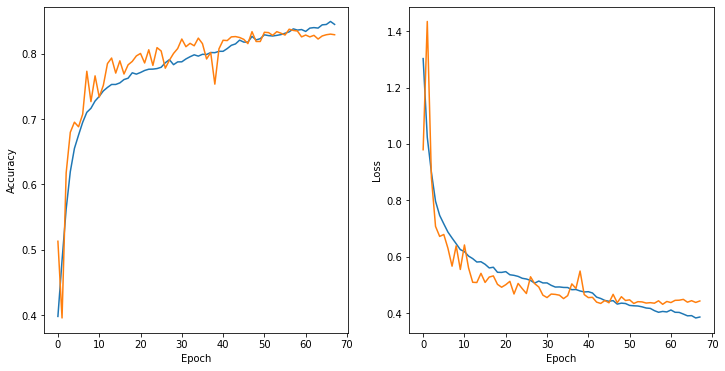

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [19]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


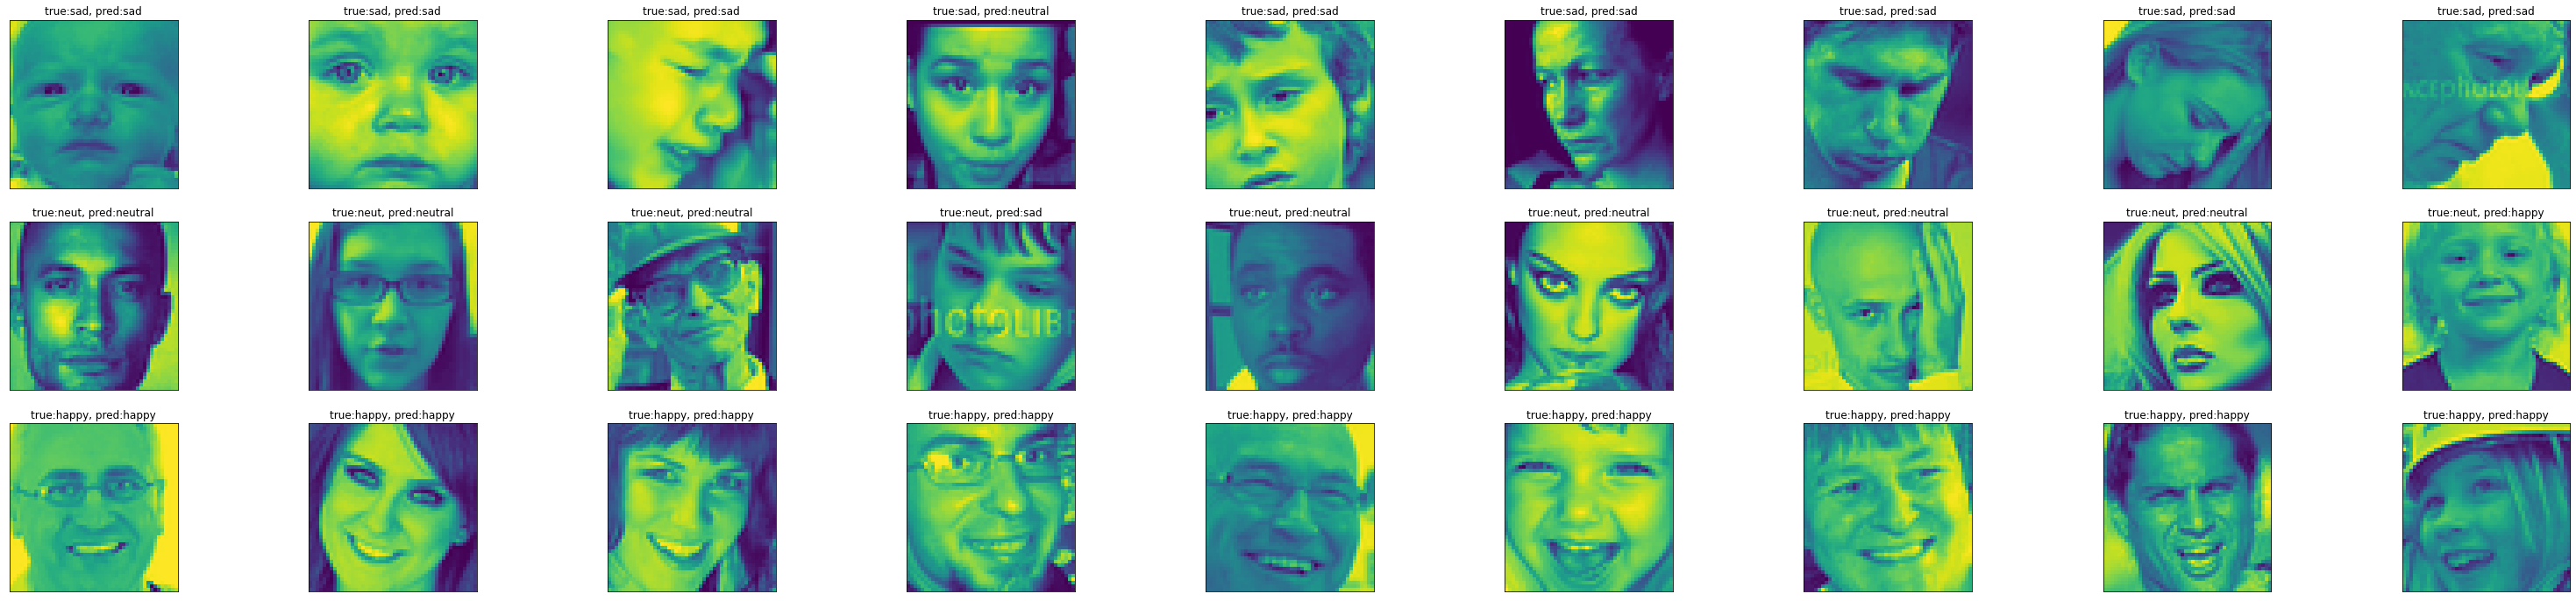

In [36]:
np.random.seed(2)
random_happy_imgs = np.random.choice(np.where(y_valid[:, 0]==1)[0], size=9)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

plt.figure(figsize=(54,12))
for i, (sadidx, neuidx, hapidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs, random_happy_imgs)):
    plt.subplot(3,9,i+1)
    sample_img = X_valid[sadidx,:,:,0]
    plt.imshow(sample_img)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

    plt.subplot(3,9,i+10)
    sample_img = X_valid[neuidx,:,:,0]
    plt.imshow(sample_img)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"true:neut, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

    plt.subplot(3,9,i+19)
    sample_img = X_valid[hapidx,:,:,0]
    plt.imshow(sample_img)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"true:happy, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")